In [45]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import napari
import tifffile
from pathlib import Path
from PIL import Image
import potrace
from skimage.color import rgb2gray

# sélection de l'image

fold_im = "/home/vladimir/Documents/Projets/segmentation/"
name_im = "2D 4C 1 _ 30.06.21 _ copie _ rl.tif"

path_im = fold_im + "/" + name_im

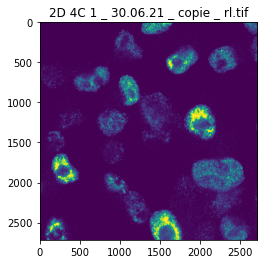

In [46]:
# affichage de l'image avec son titre

im = Image.open(path_im)
im = np.array(im)

plt.imshow(im)
plt.title(name_im)
plt.show()

In [47]:
# conversion en 16 bit

im.astype(np.uint16)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 336, 561, 448],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [ ]:
# ouverture de toutes les images d'un dossier

fold = Path(fold_im)

for img in fold.iterdir() :
    im = Image.open(img)
    im = np.array(im)
    plt.imshow(im)
    plt.show()

In [65]:
# ouverture de napari et création du mask cell

label_cells = np.zeros_like(im)
with napari.gui_qt():
    viewer = napari.view_image(im, rgb=False, name=name_im)
    viewer.add_labels(label_cells, name='mask_cells')

In [103]:
# sauvegarde du mask en fonction du nom de l'image d'origine

if Path(fold_im + '/processed').exists() :
    tifffile.imwrite(fold_im + '/processed/' + name_im + '_mask_cells.tiff', viewer.layers['seg1'].data)
else :
    new_fold = Path(fold_im + '/processed')
    new_fold.mkdir()
    tifffile.imwrite(fold_im + '/processed/' + name_im + '_mask_cells.tiff', viewer.layers['seg1'].data)

<ipython-input-48-b729c23ff01e>:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im_grayscale = rgb2gray(im)


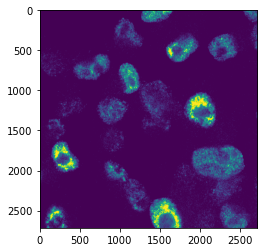

In [48]:
# conversion en nuances de gris

im_grayscale = rgb2gray(im)
plt.imshow(im_grayscale)

In [19]:
# segmentation automatique 1.0 (otsu classique)

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects

# apply threshold
thresh = threshold_otsu(im_grayscale)
bw = closing(im_grayscale > thresh, square(1))
# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 20)
# label image regions
label_image = label(cleared)

# create the viewer and add the coins image
viewer = napari.view_image(im_grayscale, name=name_im)
# add the labels
labels_layer = viewer.add_labels(label_image, name=name_im+' _segmentation mask')

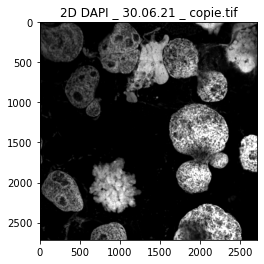

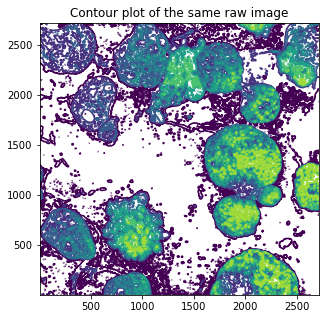

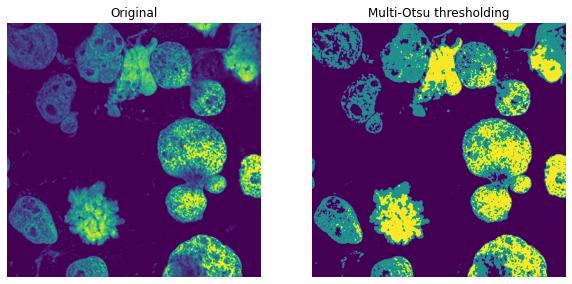

In [22]:
# segmentation automatique 2.0 (multi-otsu)

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
from skimage.data import human_mitosis

image = im_grayscale

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.set_title(name_im)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
qcs = ax.contour(image, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

thresholds = filters.threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

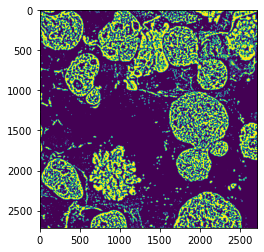

In [25]:
# segmentation automatique 3.0 (local)

from skimage.filters import threshold_otsu, threshold_local


#image = data.page()
image = im_grayscale

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 101
local_thresh = threshold_local(image, block_size, offset=0)
binary_local = image > local_thresh

plt.imshow(binary_local)





bw = closing(im_grayscale > binary_local, square(1))
# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 20)
# label image regions
label_image = label(cleared)

# create the viewer and add the coins image
viewer = napari.view_image(im_grayscale, name=name_im)
# add the labels
labels_layer = viewer.add_labels(label_image, name=name_im+' _segmentation mask')

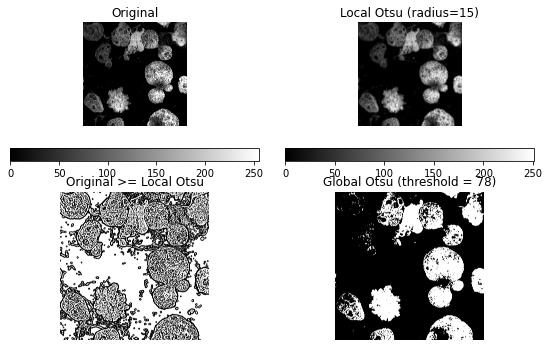

In [26]:
# segmentation automatique 4.0 (otsu local nuances de gris)

from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte


img = img_as_ubyte(im_grayscale)

radius = 15
footprint = disk(radius)

local_otsu = rank.otsu(img, footprint)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title('Local Otsu (radius=%d)' % radius)
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu' % threshold_global_otsu)
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax[3].axis('off')

plt.show()

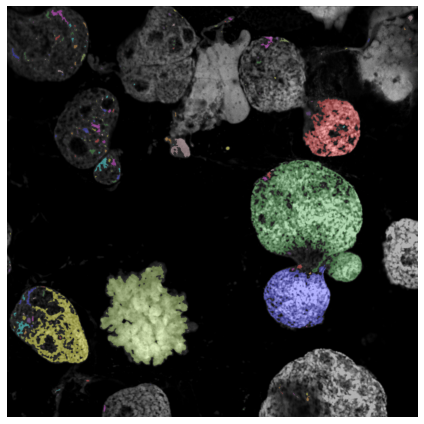

In [60]:
# segmentation automatique 5.0 (détection bords)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

image = im_grayscale

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(5))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

ax.set_axis_off()
plt.tight_layout()
plt.show()

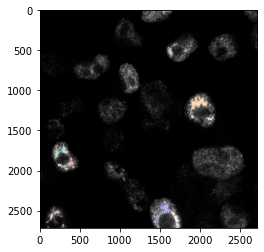

In [49]:
# segmentation automatique 6.0 (sobel) !!!!!

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data

coins = im_grayscale

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 50000] = background
markers[coins > 60000] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Show the segmentation
color1 = label2rgb(seg1, image=coins, bg_label=0)
plt.imshow(color1)

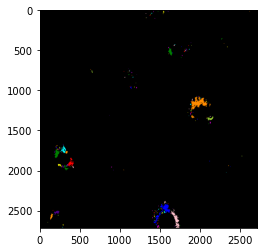

In [50]:
plt.imshow(label2rgb(seg1, bg_label=0))

In [51]:
# affichage de l'image en nuance de gris pour le seuillage
viewer = napari.view_image(im_grayscale)

In [44]:
# affichage sur napari
viewer = napari.view_image(im_grayscale)
labels_layer = viewer.add_labels(seg1)